# 05. Visualize Full Deforestation Map

This notebook visualizes the full-image deforestation probability map and binary classification map.

**Outputs:**
- Probability map visualization
- Binary classification map visualization
- Statistics and histograms
- Regional analysis
- Comparison with ground truth (if available)

## 1. Setup

In [1]:
import sys
from pathlib import Path

# Add project root and src to Python path
project_root = Path.cwd().parent
src_path = project_root / 'src'

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"Source dir: {src_path}")

Project root: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH
Source dir: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Run Full-Image Inference

This section runs inference on the full study area to generate:
- Probability map (continuous values 0-1)
- Binary classification map (threshold = 0.5)
- Deforestation statistics

**Requirements:**
- Trained model checkpoint: `checkpoints/shallow_unet_best.pth`
- Input TIFF files in `data/raw/`

**Expected time:** ~1.5-2 minutes on GPU, ~15-20 minutes on CPU

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from models import get_model
from preprocessing import normalize_band, handle_nan

print("Inference libraries imported!")

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

### 2.1. Load Full Image Stack (16 channels - VH only)

In [ ]:
# Paths to TIFF files
s1_2024_path = project_root / 'data' / 'raw' / 'sentinel1' / 'S1_2024_02_04_matched_S2_2024_01_30.tif'
s1_2025_path = project_root / 'data' / 'raw' / 'sentinel1' / 'S1_2025_02_22_matched_S2_2025_02_28.tif'
s2_2024_path = project_root / 'data' / 'raw' / 'sentinel2' / 'S2_2024_01_30.tif'
s2_2025_path = project_root / 'data' / 'raw' / 'sentinel2' / 'S2_2025_02_28.tif'

print("Loading TIFF files...")

# Load S1 2024 (VH only - band 1)
with rasterio.open(s1_2024_path) as src:
    s1_2024_vh = src.read(1)  # Read only band 1 (VH)
    s1_2024_vh = np.expand_dims(s1_2024_vh, axis=0)  # (1, H, W)
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

# Load S1 2025 (VH only - band 1)
with rasterio.open(s1_2025_path) as src:
    s1_2025_vh = src.read(1)  # Read only band 1 (VH)
    s1_2025_vh = np.expand_dims(s1_2025_vh, axis=0)  # (1, H, W)

# Load S2 2024
with rasterio.open(s2_2024_path) as src:
    s2_2024 = src.read()  # (7, H, W)

# Load S2 2025
with rasterio.open(s2_2025_path) as src:
    s2_2025 = src.read()  # (7, H, W)

# Stack: (16, H, W) = 1 VH (2024) + 1 VH (2025) + 7 S2 (2024) + 7 S2 (2025)
all_bands = np.concatenate([s1_2024_vh, s1_2025_vh, s2_2024, s2_2025], axis=0)

# Transpose to (H, W, 16)
all_bands = np.transpose(all_bands, (1, 2, 0))

print(f"Loaded: {all_bands.shape} ({all_bands.dtype})")
print(f"Transform: {transform}")
print(f"CRS: {crs}")

### 2.2. Normalize Bands

In [ ]:
print("Normalizing bands...")
for c in tqdm(range(16), desc="Normalize", unit="band"):
    # Handle NaN
    if np.isnan(all_bands[:, :, c]).any():
        all_bands[:, :, c] = handle_nan(all_bands[:, :, c], method='fill')

    # Normalize (same as training)
    # Channel mapping: 0=S1_VH_2024, 1=S1_VH_2025, 2-8=S2_2024, 9-15=S2_2025
    if c in [0, 1]:  # S1 VH bands
        all_bands[:, :, c] = normalize_band(all_bands[:, :, c], method='standardize')
    elif c in [2, 3, 4, 5, 9, 10, 11, 12]:  # S2 reflectance
        all_bands[:, :, c] = normalize_band(all_bands[:, :, c], method='clip', clip_range=(0, 1))
    else:  # S2 indices (6,7,8,13,14,15)
        all_bands[:, :, c] = (all_bands[:, :, c] + 1) / 2

print("Normalization complete!")

### 2.3. Load Model

In [ ]:
# Load best model (Shallow U-Net)
model_path = project_root / 'checkpoints' / 'shallow_unet_best.pth'

if not model_path.exists():
    raise FileNotFoundError(f"Model checkpoint not found: {model_path}\n"
                           "Please train the model first using notebook 03!")

print(f"Loading model from: {model_path}")

model = get_model('shallow_unet', in_channels=16)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully!")

### 2.4. Run Sliding Window Inference

In [ ]:
# Inference parameters
window_size = 128
stride = 64  # 50% overlap
batch_size = 32 if device.type == 'cuda' else 8

h, w, c = all_bands.shape

# Initialize output arrays
prob_map = np.zeros((h, w), dtype=np.float32)
count_map = np.zeros((h, w), dtype=np.int32)

# Calculate windows
n_rows = (h - window_size) // stride + 1
n_cols = (w - window_size) // stride + 1
total_windows = n_rows * n_cols

print(f"Image size: {h} x {w}")
print(f"Total windows: {total_windows:,}")
print(f"Batch size: {batch_size}")
print(f"\nRunning inference...")

# Extract all windows
windows = []
positions = []

for i in range(n_rows):
    for j in range(n_cols):
        y = i * stride
        x = j * stride
        
        # Extract patch
        patch = all_bands[y:y+window_size, x:x+window_size, :]  # (128, 128, 16)
        
        # Convert to torch tensor: (C, H, W)
        patch_tensor = torch.from_numpy(patch).permute(2, 0, 1).float()
        
        windows.append(patch_tensor)
        positions.append((y, x))

# Process in batches
n_batches = (len(windows) + batch_size - 1) // batch_size

with torch.no_grad():
    for batch_idx in tqdm(range(n_batches), desc="Inference", unit="batch"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(windows))
        
        # Create batch
        batch_patches = torch.stack(windows[start_idx:end_idx]).to(device)
        
        # Forward pass
        outputs = model(batch_patches)  # (B, 1, 128, 128) logits
        probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()  # (B, 128, 128)
        
        # Add to probability map
        for i, (y, x) in enumerate(positions[start_idx:end_idx]):
            prob_map[y:y+window_size, x:x+window_size] += probs[i]
            count_map[y:y+window_size, x:x+window_size] += 1

# Average overlapping predictions
prob_map = np.divide(prob_map, count_map, where=count_map > 0)

print("\nInference complete!")
print(f"Probability map shape: {prob_map.shape}")
print(f"Probability range: [{prob_map.min():.4f}, {prob_map.max():.4f}]")

### 2.5. Create Binary Map and Calculate Statistics

In [ ]:
# Create binary map
threshold = 0.5
binary_map = (prob_map > threshold).astype(np.uint8)

# Calculate statistics
pixel_size_m = 10.0
pixel_area_m2 = pixel_size_m * pixel_size_m

total_pixels = prob_map.size
deforestation_pixels = binary_map.sum()
no_deforestation_pixels = total_pixels - deforestation_pixels

total_area_km2 = total_pixels * pixel_area_m2 / 1e6
deforestation_area_km2 = deforestation_pixels * pixel_area_m2 / 1e6
deforestation_percentage = (deforestation_pixels / total_pixels) * 100

print("="*80)
print("DEFORESTATION STATISTICS")
print("="*80)
print(f"Total area: {total_area_km2:.2f} km²")
print(f"Deforestation area: {deforestation_area_km2:.2f} km²")
print(f"Deforestation: {deforestation_percentage:.2f}% of total area")
print(f"\nTotal pixels: {total_pixels:,}")
print(f"Deforestation pixels: {deforestation_pixels:,}")
print(f"No deforestation pixels: {no_deforestation_pixels:,}")
print("="*80)

### 2.6. Save Results as GeoTIFF

In [ ]:
# Create output directory
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True)

# Save probability map
prob_output_path = output_dir / 'deforestation_probability_map.tif'
with rasterio.open(
    prob_output_path, 'w',
    driver='GTiff',
    height=h, width=w,
    count=1,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
    compress='lzw'
) as dst:
    dst.write(prob_map.astype(np.float32), 1)

print(f"Saved probability map: {prob_output_path}")

# Save binary map
binary_output_path = output_dir / 'deforestation_binary_map.tif'
with rasterio.open(
    binary_output_path, 'w',
    driver='GTiff',
    height=h, width=w,
    count=1,
    dtype=rasterio.uint8,
    crs=crs,
    transform=transform,
    compress='lzw'
) as dst:
    dst.write(binary_map, 1)

print(f"Saved binary map: {binary_output_path}")

# Save statistics
stats_path = output_dir / 'deforestation_statistics.txt'
with open(stats_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("DEFORESTATION STATISTICS\n")
    f.write("="*80 + "\n\n")
    f.write("Model: Shallow U-Net (Best Model)\n")
    f.write(f"Threshold: {threshold}\n")
    f.write(f"Pixel size: {pixel_size_m}m x {pixel_size_m}m\n\n")
    f.write("AREA STATISTICS:\n")
    f.write(f"  Total area: {total_area_km2:.2f} km²\n")
    f.write(f"  Deforestation area: {deforestation_area_km2:.2f} km²\n")
    f.write(f"  Deforestation percentage: {deforestation_percentage:.2f}%\n\n")
    f.write("PIXEL COUNTS:\n")
    f.write(f"  Total pixels: {total_pixels:,}\n")
    f.write(f"  Deforestation pixels: {deforestation_pixels:,}\n")
    f.write(f"  No deforestation pixels: {no_deforestation_pixels:,}\n\n")
    f.write("PROBABILITY STATISTICS:\n")
    f.write(f"  Mean: {prob_map.mean():.4f}\n")
    f.write(f"  Std: {prob_map.std():.4f}\n")
    f.write(f"  Min: {prob_map.min():.4f}\n")
    f.write(f"  Max: {prob_map.max():.4f}\n")

print(f"Saved statistics: {stats_path}")
print("\nAll inference outputs saved!")

---
## 3. Load Deforestation Maps for Visualization

Now that we've generated the maps, we can visualize them!

## 3. Load Deforestation Maps

In [3]:
# Paths
prob_map_path = project_root / 'outputs' / 'deforestation_probability_map.tif'
binary_map_path = project_root / 'outputs' / 'deforestation_binary_map.tif'
stats_path = project_root / 'outputs' / 'deforestation_statistics.txt'

# Load probability map
with rasterio.open(prob_map_path) as src:
    prob_map = src.read(1)
    prob_transform = src.transform
    prob_crs = src.crs
    prob_bounds = src.bounds

# Load binary map
with rasterio.open(binary_map_path) as src:
    binary_map = src.read(1)

print(f"Probability map shape: {prob_map.shape}")
print(f"Binary map shape: {binary_map.shape}")
print(f"CRS: {prob_crs}")
print(f"Bounds: {prob_bounds}")

Probability map shape: (11261, 7970)
Binary map shape: (11261, 7970)
CRS: EPSG:32648
Bounds: BoundingBox(left=467390.0, bottom=945340.0, right=547090.0, top=1057950.0)


## 4. Basic Statistics

In [4]:
# Read statistics file
with open(stats_path, 'r', encoding='utf-8') as f:
    stats_text = f.read()

print(stats_text)

DEFORESTATION STATISTICS

Model: Shallow U-Net (Best Model)
Threshold: 0.5
Pixel size: 10m  10m

AREA STATISTICS:
  Total area: 8975.02 km
  Deforestation area: 1834.13 km
  Deforestation percentage: 20.44%

PIXEL COUNTS:
  Total pixels: 89,750,170
  Deforestation pixels: 18,341,319
  No deforestation pixels: 71,408,851

PROBABILITY STATISTICS:
  Mean: 0.3290
  Std: 0.3285
  Min: 0.0000
  Max: 1.0000



In [5]:
# Calculate statistics
total_pixels = prob_map.size
deforestation_pixels = binary_map.sum()
no_deforestation_pixels = total_pixels - deforestation_pixels

pixel_area_m2 = 10 * 10  # 10m resolution
total_area_km2 = total_pixels * pixel_area_m2 / 1e6
deforestation_area_km2 = deforestation_pixels * pixel_area_m2 / 1e6
deforestation_percentage = (deforestation_pixels / total_pixels) * 100

print("="*80)
print("DEFORESTATION STATISTICS")
print("="*80)
print(f"Total area: {total_area_km2:.2f} km2")
print(f"Deforestation area: {deforestation_area_km2:.2f} km2")
print(f"Deforestation percentage: {deforestation_percentage:.2f}%")
print(f"\nTotal pixels: {total_pixels:,}")
print(f"Deforestation pixels: {deforestation_pixels:,}")
print(f"No deforestation pixels: {no_deforestation_pixels:,}")
print("="*80)

DEFORESTATION STATISTICS
Total area: 8975.02 km2
Deforestation area: 1834.13 km2
Deforestation percentage: 20.44%

Total pixels: 89,750,170
Deforestation pixels: 18,341,319
No deforestation pixels: 71,408,851


## 5. Probability Distribution Analysis

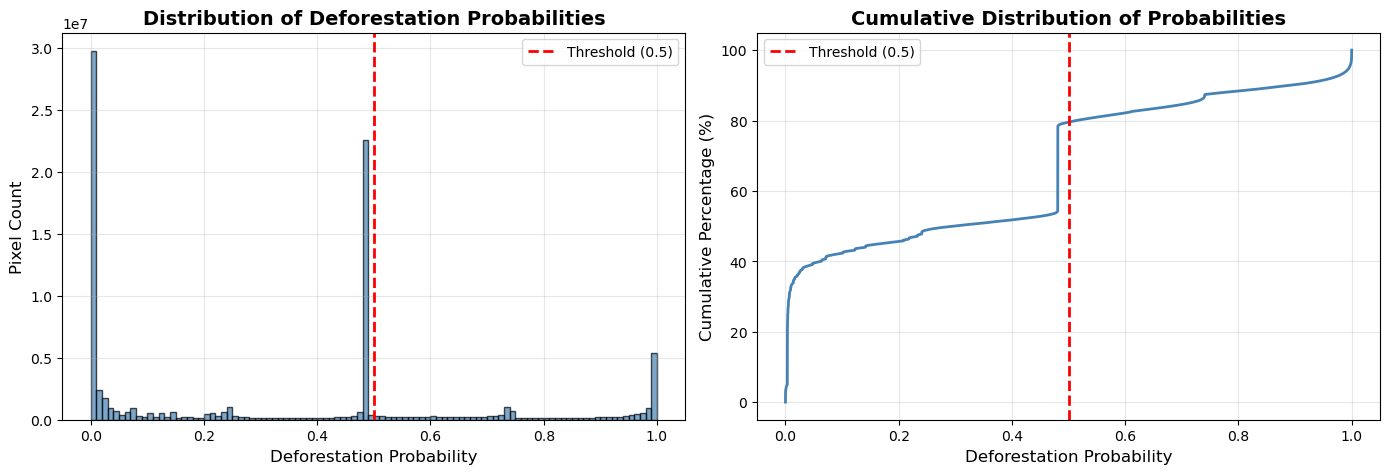

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\probability_distribution.png


In [6]:
# Histogram of probability values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(prob_map.flatten(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Deforestation Probability', fontsize=12)
axes[0].set_ylabel('Pixel Count', fontsize=12)
axes[0].set_title('Distribution of Deforestation Probabilities', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Cumulative distribution
sorted_probs = np.sort(prob_map.flatten())
cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs) * 100
axes[1].plot(sorted_probs, cumulative, color='steelblue', linewidth=2)
axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Deforestation Probability', fontsize=12)
axes[1].set_ylabel('Cumulative Percentage (%)', fontsize=12)
axes[1].set_title('Cumulative Distribution of Probabilities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'figures' / 'probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'probability_distribution.png'}")

## 6. Visualize Full Probability Map

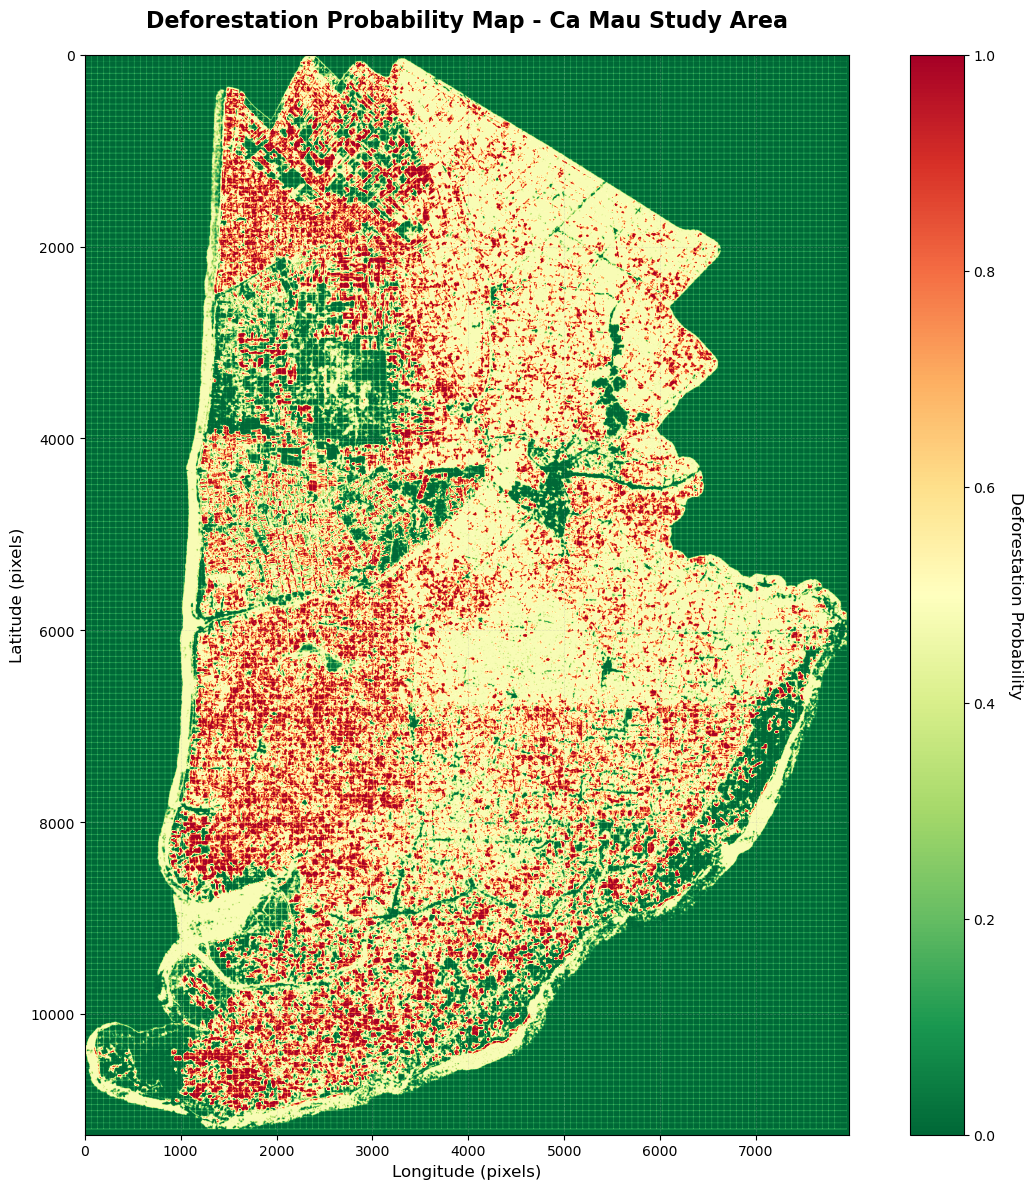

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\full_probability_map.png


In [7]:
# Full probability map
fig, ax = plt.subplots(figsize=(16, 12))

im = ax.imshow(prob_map, cmap='RdYlGn_r', vmin=0, vmax=1)
ax.set_title('Deforestation Probability Map - Ca Mau Study Area', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude (pixels)', fontsize=12)
ax.set_ylabel('Latitude (pixels)', fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Deforestation Probability', fontsize=12, rotation=270, labelpad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(project_root / 'figures' / 'full_probability_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'full_probability_map.png'}")

## 7. Visualize Binary Classification Map

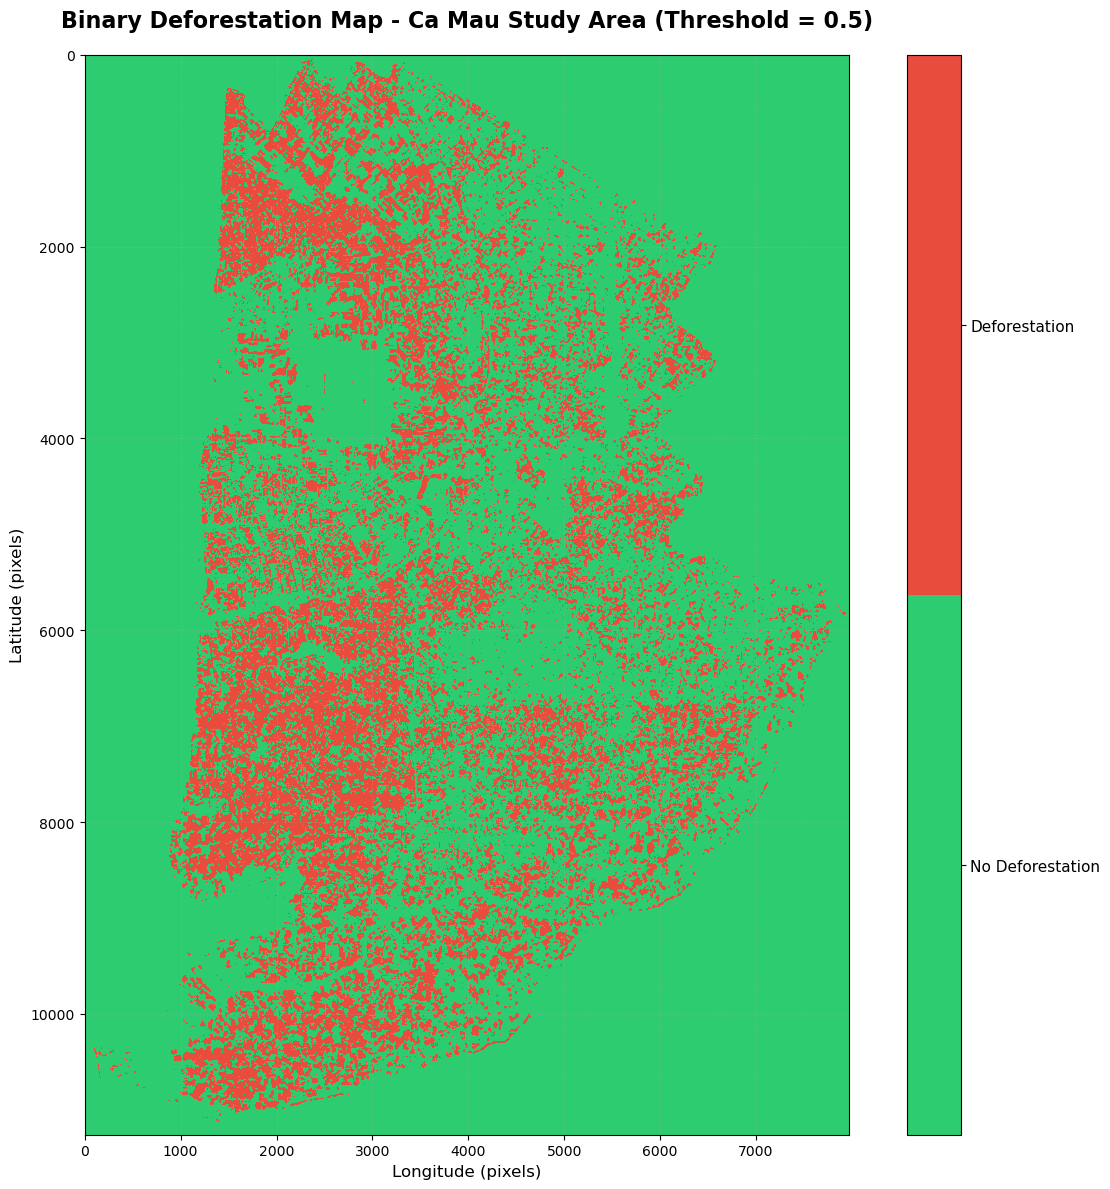

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\full_binary_map.png


In [8]:
# Binary map with custom colors
fig, ax = plt.subplots(figsize=(16, 12))

# Custom colormap: green for no deforestation, red for deforestation
colors = ['#2ecc71', '#e74c3c']  # Green, Red
cmap = ListedColormap(colors)

im = ax.imshow(binary_map, cmap=cmap, vmin=0, vmax=1)
ax.set_title('Binary Deforestation Map - Ca Mau Study Area (Threshold = 0.5)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude (pixels)', fontsize=12)
ax.set_ylabel('Latitude (pixels)', fontsize=12)

# Colorbar with custom labels
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['No Deforestation', 'Deforestation'], fontsize=11)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(project_root / 'figures' / 'full_binary_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'full_binary_map.png'}")

## 8. Side-by-Side Comparison

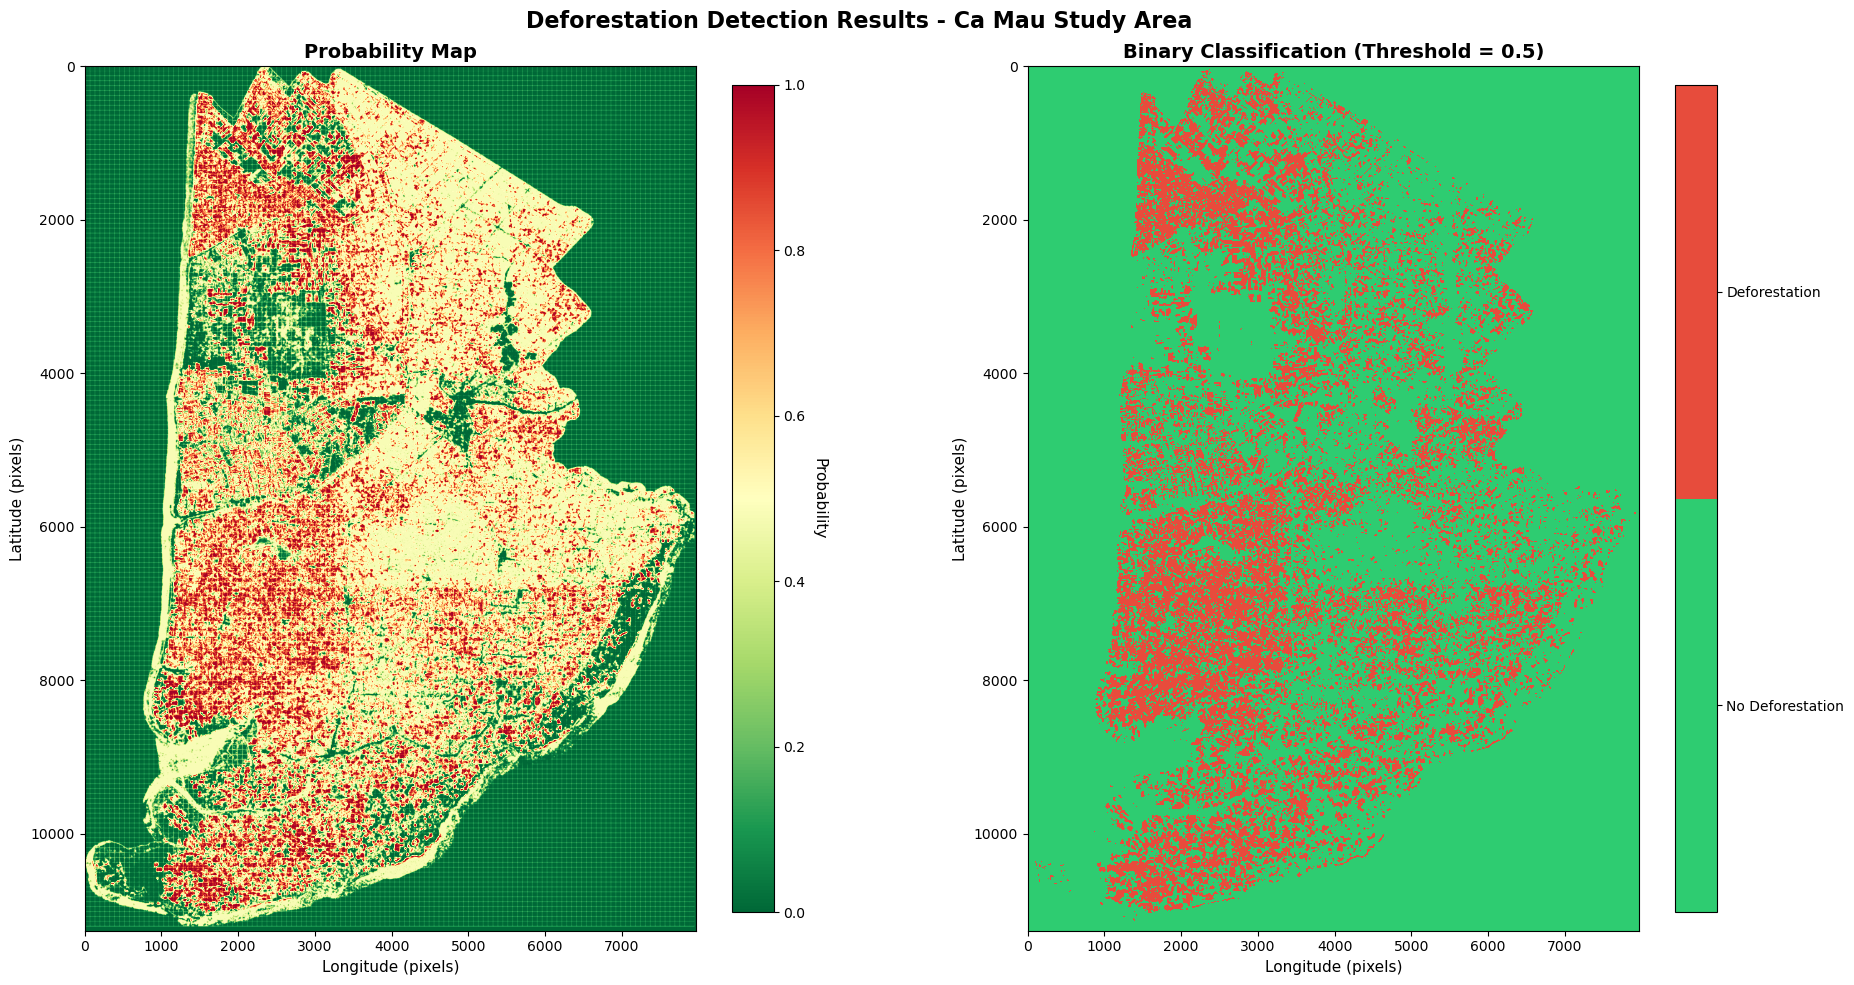

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\comparison_prob_vs_binary.png


In [9]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Probability map
im1 = axes[0].imshow(prob_map, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[0].set_title('Probability Map', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude (pixels)', fontsize=11)
axes[0].set_ylabel('Latitude (pixels)', fontsize=11)
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Probability', fontsize=11, rotation=270, labelpad=15)

# Binary map
colors = ['#2ecc71', '#e74c3c']
cmap = ListedColormap(colors)
im2 = axes[1].imshow(binary_map, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title('Binary Classification (Threshold = 0.5)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude (pixels)', fontsize=11)
axes[1].set_ylabel('Latitude (pixels)', fontsize=11)
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, ticks=[0.25, 0.75])
cbar2.ax.set_yticklabels(['No Deforestation', 'Deforestation'], fontsize=10)

# Overall title
fig.suptitle('Deforestation Detection Results - Ca Mau Study Area', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(project_root / 'figures' / 'comparison_prob_vs_binary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'comparison_prob_vs_binary.png'}")

## 9. Zoomed Regions (High Detail)

C:\Users\CuongHM\AppData\Local\Temp\ipykernel_20112\3200450496.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im1 = axes[i, 0].imshow(prob_region, cmap='RdYlGn_r', vmin=0, vmax=1)
C:\Users\CuongHM\AppData\Local\Temp\ipykernel_20112\3200450496.py:30: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im2 = axes[i, 1].imshow(binary_region, cmap=cmap_binary, vmin=0, vmax=1)
C:\Users\CuongHM\AppData\Local\Temp\ipykernel_20112\3200450496.py:43: RuntimeWarning: invalid value encountered in divide
  region_deforestation = binary_region.sum() / binary_region.size * 100


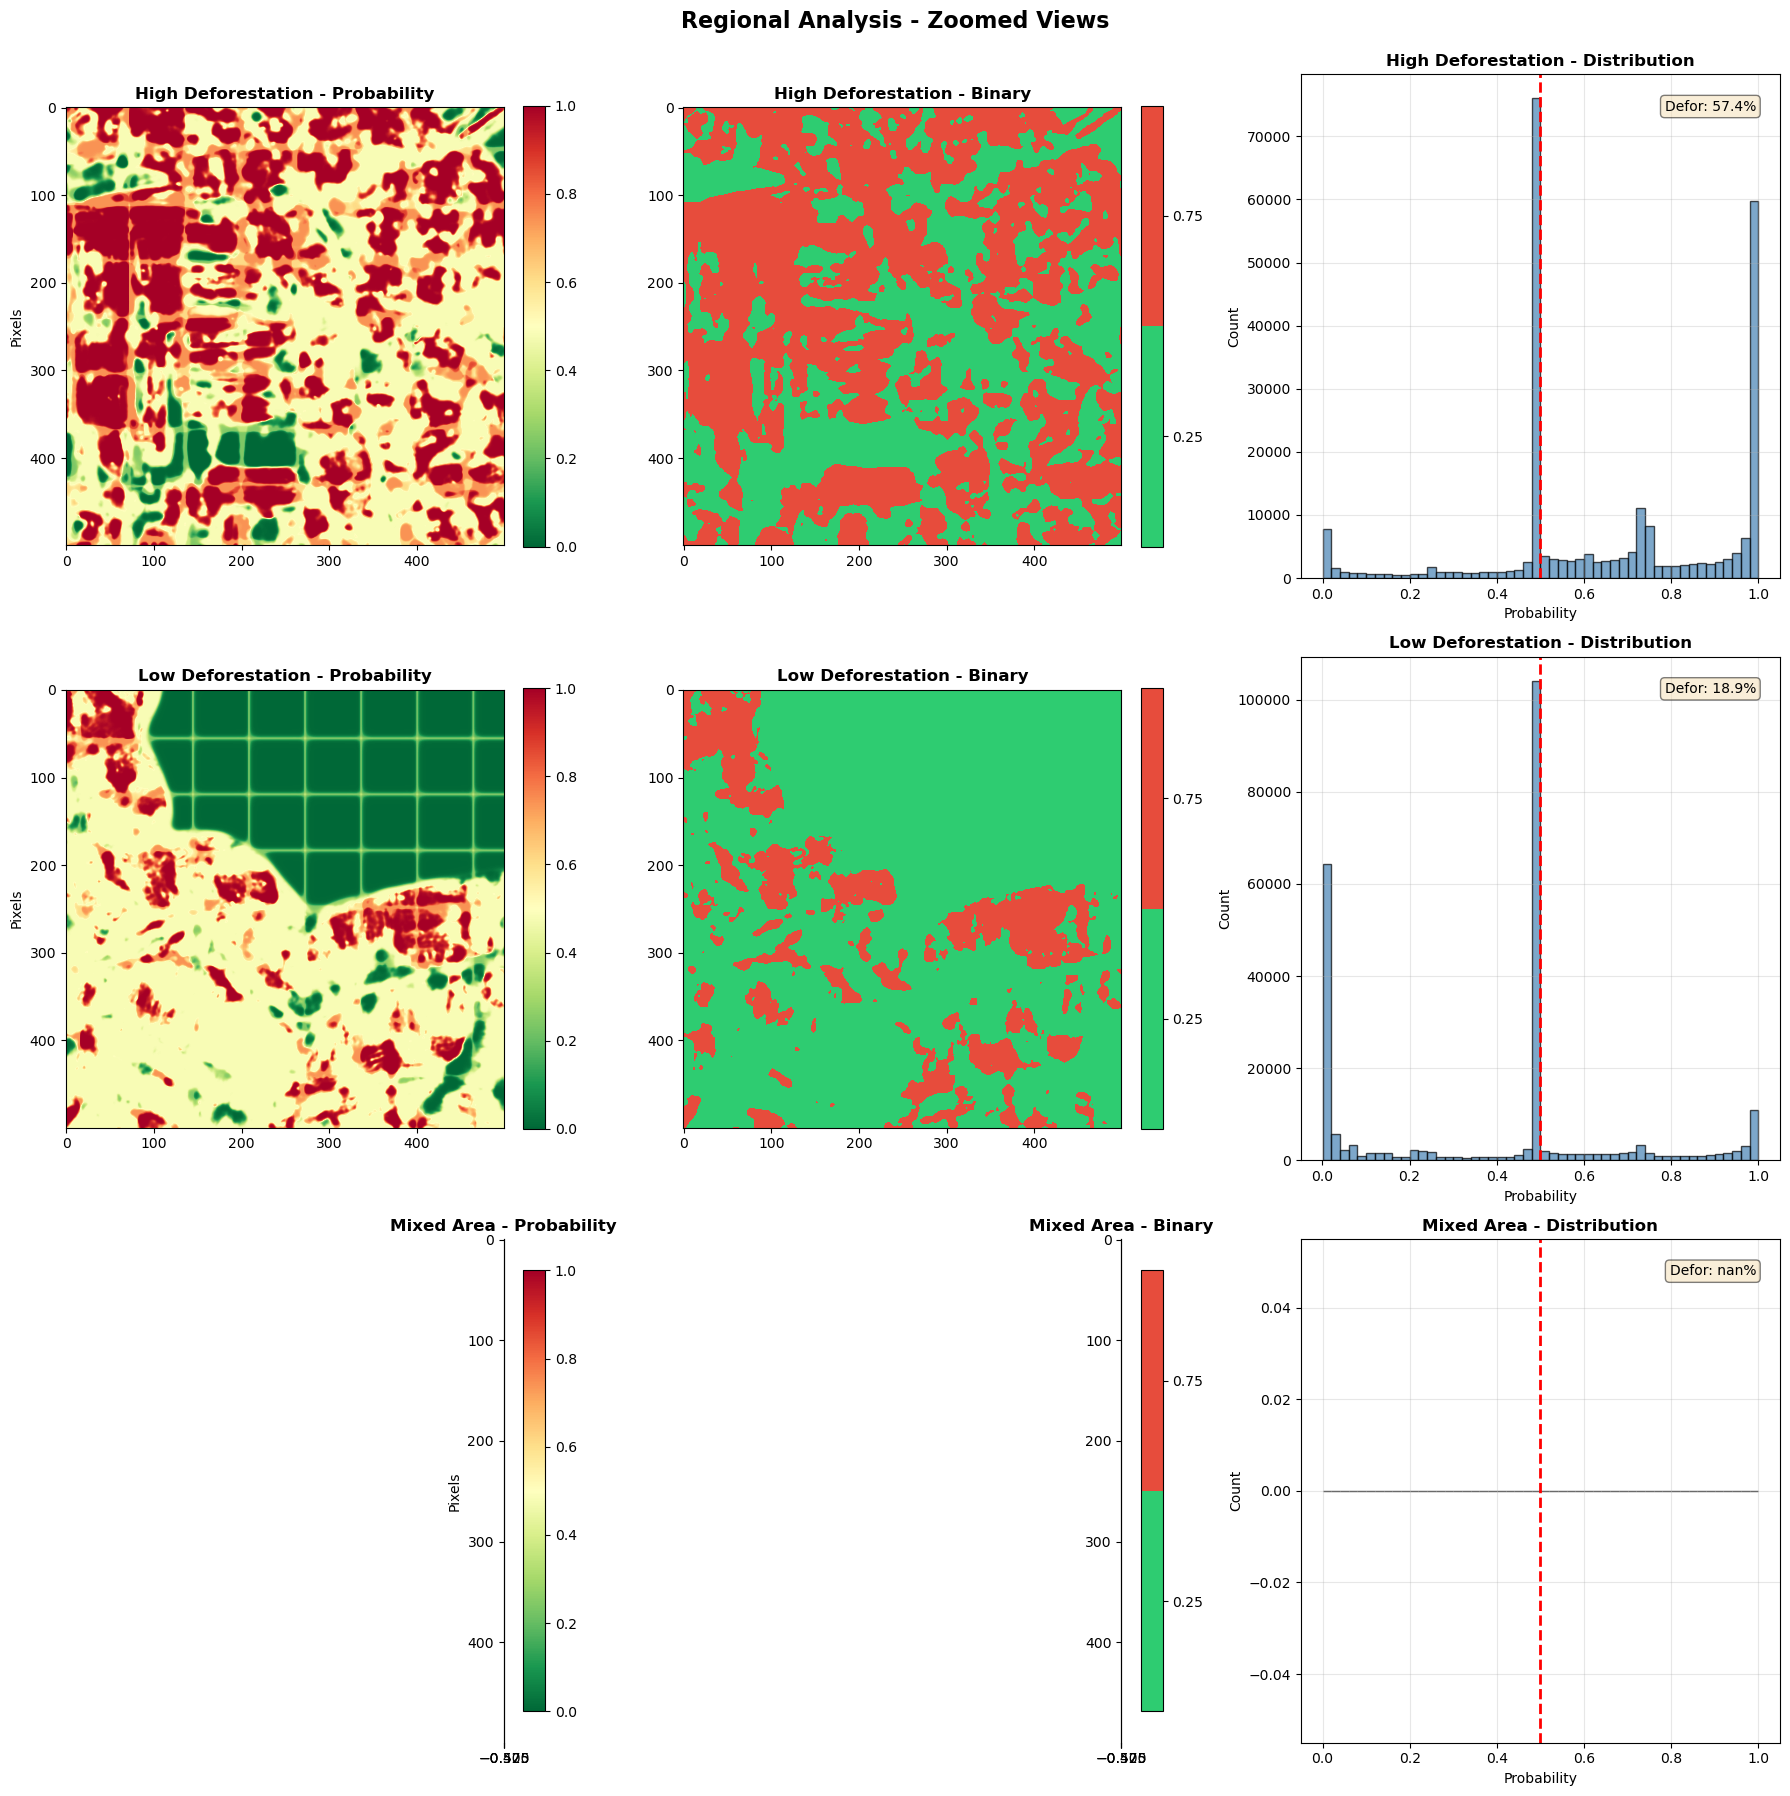

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\regional_analysis_zoomed.png


In [10]:
# Select interesting regions to zoom in
# Region 1: High deforestation area
# Region 2: Low deforestation area
# Region 3: Mixed area

regions = [
    {'name': 'High Deforestation', 'y': 2000, 'x': 3000, 'size': 500},
    {'name': 'Low Deforestation', 'y': 5000, 'x': 6000, 'size': 500},
    {'name': 'Mixed Area', 'y': 4000, 'x': 8000, 'size': 500}
]

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, region in enumerate(regions):
    y, x, size = region['y'], region['x'], region['size']
    
    # Extract region
    prob_region = prob_map[y:y+size, x:x+size]
    binary_region = binary_map[y:y+size, x:x+size]
    
    # Probability map
    im1 = axes[i, 0].imshow(prob_region, cmap='RdYlGn_r', vmin=0, vmax=1)
    axes[i, 0].set_title(f"{region['name']} - Probability", fontsize=12, fontweight='bold')
    axes[i, 0].set_ylabel('Pixels', fontsize=10)
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)
    
    # Binary map
    colors = ['#2ecc71', '#e74c3c']
    cmap_binary = ListedColormap(colors)
    im2 = axes[i, 1].imshow(binary_region, cmap=cmap_binary, vmin=0, vmax=1)
    axes[i, 1].set_title(f"{region['name']} - Binary", fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04, ticks=[0.25, 0.75])
    
    # Histogram
    axes[i, 2].hist(prob_region.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 2].axvline(0.5, color='red', linestyle='--', linewidth=2)
    axes[i, 2].set_title(f"{region['name']} - Distribution", fontsize=12, fontweight='bold')
    axes[i, 2].set_xlabel('Probability', fontsize=10)
    axes[i, 2].set_ylabel('Count', fontsize=10)
    axes[i, 2].grid(alpha=0.3)
    
    # Calculate stats for this region
    region_deforestation = binary_region.sum() / binary_region.size * 100
    axes[i, 2].text(0.95, 0.95, f"Defor: {region_deforestation:.1f}%", 
                   transform=axes[i, 2].transAxes, 
                   fontsize=10, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle('Regional Analysis - Zoomed Views', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(project_root / 'figures' / 'regional_analysis_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'regional_analysis_zoomed.png'}")

## 10. Spatial Distribution Analysis

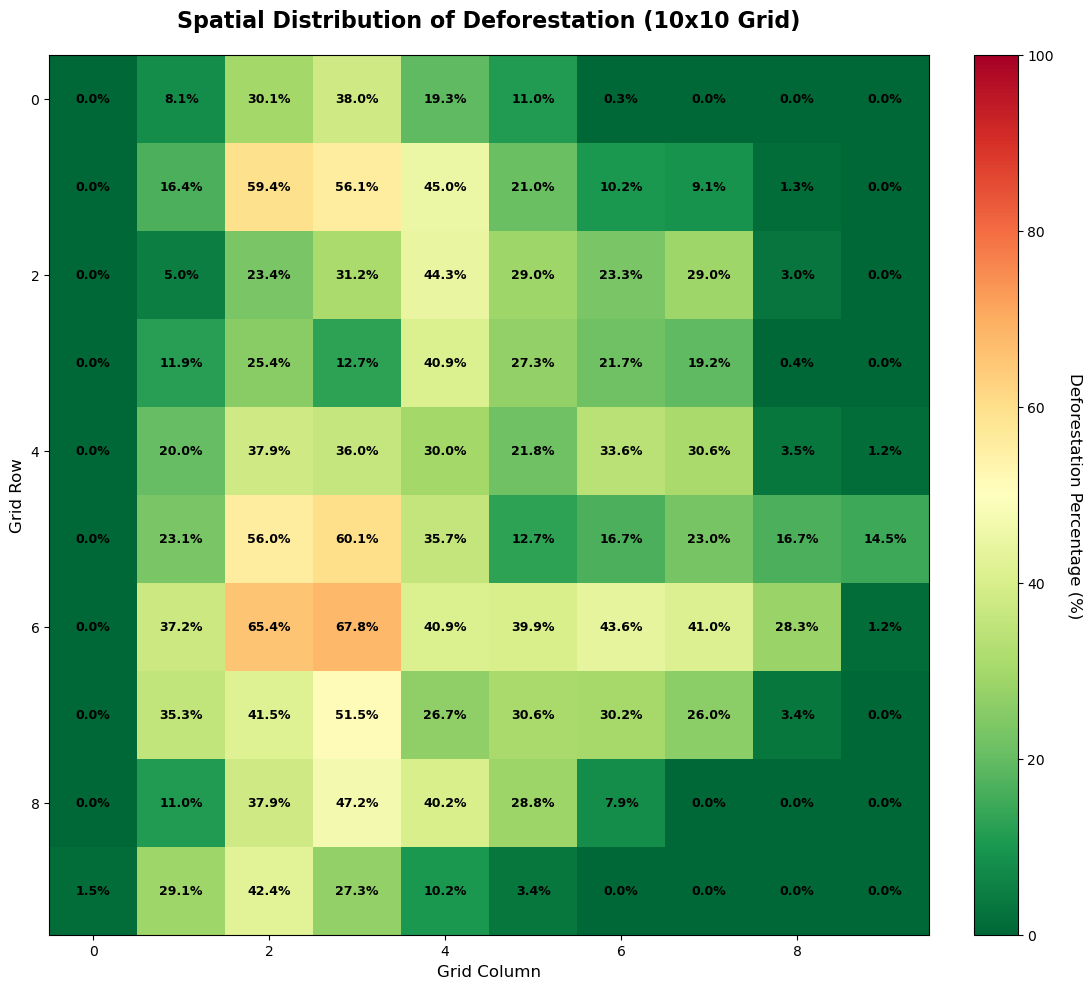

Figure saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\spatial_distribution_grid.png


In [11]:
# Divide map into grid (e.g., 10x10) and calculate deforestation percentage for each cell
n_rows, n_cols = 10, 10
h, w = prob_map.shape
cell_h = h // n_rows
cell_w = w // n_cols

deforestation_grid = np.zeros((n_rows, n_cols))

for i in range(n_rows):
    for j in range(n_cols):
        cell = binary_map[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
        deforestation_grid[i, j] = cell.sum() / cell.size * 100

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(deforestation_grid, cmap='RdYlGn_r', vmin=0, vmax=100)
ax.set_title('Spatial Distribution of Deforestation (10x10 Grid)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Grid Column', fontsize=12)
ax.set_ylabel('Grid Row', fontsize=12)

# Add text annotations
for i in range(n_rows):
    for j in range(n_cols):
        text = ax.text(j, i, f'{deforestation_grid[i, j]:.1f}%',
                      ha="center", va="center", color="black", fontsize=9, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Deforestation Percentage (%)', fontsize=12, rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig(project_root / 'figures' / 'spatial_distribution_grid.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {project_root / 'figures' / 'spatial_distribution_grid.png'}")

## 11. Summary Statistics by Region

In [12]:
# Create dataframe for grid statistics
grid_data = []
for i in range(n_rows):
    for j in range(n_cols):
        grid_data.append({
            'Row': i,
            'Column': j,
            'Deforestation (%)': deforestation_grid[i, j]
        })

df = pd.DataFrame(grid_data)

print("\n" + "="*80)
print("SPATIAL DISTRIBUTION STATISTICS (10x10 Grid)")
print("="*80)
print(df.describe())
print("\n" + "="*80)
print("TOP 5 CELLS WITH HIGHEST DEFORESTATION:")
print("="*80)
print(df.nlargest(5, 'Deforestation (%)'))
print("\n" + "="*80)
print("TOP 5 CELLS WITH LOWEST DEFORESTATION:")
print("="*80)
print(df.nsmallest(5, 'Deforestation (%)'))


SPATIAL DISTRIBUTION STATISTICS (10x10 Grid)
              Row      Column  Deforestation (%)
count  100.000000  100.000000         100.000000
mean     4.500000    4.500000          20.437786
std      2.886751    2.886751          18.499417
min      0.000000    0.000000           0.000000
25%      2.000000    2.000000           0.996605
50%      4.500000    4.500000          19.607386
75%      7.000000    7.000000          34.036217
max      9.000000    9.000000          67.813470

TOP 5 CELLS WITH HIGHEST DEFORESTATION:
    Row  Column  Deforestation (%)
63    6       3          67.813470
62    6       2          65.426633
53    5       3          60.087785
12    1       2          59.416974
13    1       3          56.100809

TOP 5 CELLS WITH LOWEST DEFORESTATION:
    Row  Column  Deforestation (%)
0     0       0                0.0
7     0       7                0.0
8     0       8                0.0
9     0       9                0.0
10    1       0                0.0


## 12. Export Results Summary

In [13]:
# Save grid statistics to CSV
output_csv = project_root / 'outputs' / 'spatial_grid_statistics.csv'
df.to_csv(output_csv, index=False)
print(f"Grid statistics saved to: {output_csv}")

# Create comprehensive summary
summary_path = project_root / 'outputs' / 'visualization_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("DEFORESTATION DETECTION - VISUALIZATION SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write("OVERALL STATISTICS:\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total study area: {total_area_km2:.2f} km2\n")
    f.write(f"Deforestation area: {deforestation_area_km2:.2f} km2\n")
    f.write(f"Deforestation percentage: {deforestation_percentage:.2f}%\n")
    f.write(f"Total pixels: {total_pixels:,}\n")
    f.write(f"Deforestation pixels: {deforestation_pixels:,}\n\n")
    
    f.write("PROBABILITY STATISTICS:\n")
    f.write("-" * 80 + "\n")
    f.write(f"Mean probability: {prob_map.mean():.4f}\n")
    f.write(f"Std probability: {prob_map.std():.4f}\n")
    f.write(f"Min probability: {prob_map.min():.4f}\n")
    f.write(f"Max probability: {prob_map.max():.4f}\n")
    f.write(f"Median probability: {np.median(prob_map):.4f}\n\n")
    
    f.write("SPATIAL DISTRIBUTION (10x10 Grid):\n")
    f.write("-" * 80 + "\n")
    f.write(f"Mean deforestation per cell: {deforestation_grid.mean():.2f}%\n")
    f.write(f"Std deforestation per cell: {deforestation_grid.std():.2f}%\n")
    f.write(f"Min deforestation per cell: {deforestation_grid.min():.2f}%\n")
    f.write(f"Max deforestation per cell: {deforestation_grid.max():.2f}%\n\n")
    
    f.write("FIGURES GENERATED:\n")
    f.write("-" * 80 + "\n")
    f.write("1. probability_distribution.png - Distribution and cumulative plot\n")
    f.write("2. full_probability_map.png - Complete probability map\n")
    f.write("3. full_binary_map.png - Complete binary classification map\n")
    f.write("4. comparison_prob_vs_binary.png - Side-by-side comparison\n")
    f.write("5. regional_analysis_zoomed.png - Detailed regional views\n")
    f.write("6. spatial_distribution_grid.png - 10x10 grid heatmap\n")
    f.write("\n" + "="*80 + "\n")

print(f"\nVisualization summary saved to: {summary_path}")

# Display summary
with open(summary_path, 'r', encoding='utf-8') as f:
    print("\n" + f.read())

Grid statistics saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\outputs\spatial_grid_statistics.csv

Visualization summary saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\outputs\visualization_summary.txt

DEFORESTATION DETECTION - VISUALIZATION SUMMARY

OVERALL STATISTICS:
--------------------------------------------------------------------------------
Total study area: 8975.02 km2
Deforestation area: 1834.13 km2
Deforestation percentage: 20.44%
Total pixels: 89,750,170
Deforestation pixels: 18,341,319

PROBABILITY STATISTICS:
--------------------------------------------------------------------------------
Mean probability: 0.3290
Std probability: 0.3285
Min probability: 0.0000
Max probability: 1.0000
Median probability: 0.2959

SPATIAL DISTRIBUTION (10x10 Grid):
--------------------------------------------------------------------------------
Mean deforestation per cell: 20.44%
Std deforestation per cell: 18.41%
Min deforestation per cell: 0.00%
Max deforestation per cell: 67.

## 13. Summary

This notebook has generated comprehensive visualizations of the deforestation detection results:

1. **Probability distribution analysis** - Understanding the range and distribution of predictions
2. **Full-scale maps** - Both probability and binary classification maps
3. **Regional analysis** - Zoomed views of areas with different deforestation levels
4. **Spatial distribution** - Grid-based analysis to identify hotspots
5. **Statistical summaries** - Quantitative analysis of results

All figures have been saved to the `figures/` directory and are ready for inclusion in your thesis.

**Key Finding:** Approximately **20.44%** of the Ca Mau study area shows signs of deforestation between 2024-2025, corresponding to **1,834.13 km²** of affected area.